In [1]:
import re
import torch
import json

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain import HuggingFacePipeline

from stockfish import Stockfish
import chess

/home/antonio/anaconda3/envs/chess_bot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load LLM

## BnB Config

In [2]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_use_double_quant=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.bfloat16
)

## Load Model and Tokenizer

In [3]:
#model_id = "meta-llama/Llama-2-7b-chat-hf"
#model_id = "mistralai/Mistral-7B-Instruct-v0.1"
#model_id = "HuggingFaceH4/zephyr-7b-beta"
model_id = "meta-llama/Llama-2-13b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_id,
                                            quantization_config=bnb_config,
                                            load_in_4bit=True,
                                            use_cache=False, 
                                            device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 3/3 [00:42<00:00, 14.27s/it]


## Load HuggingFacePipeline from langchain

In [4]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer, 
    max_length=512,
    temperature=0.00001,
    #top_p=0.15,
    #repetition_penalty=1
)

local_llm = HuggingFacePipeline(pipeline=pipe)

# Functions

In [5]:
def init_json_chat_history():
    json_chat_history = {"Opponent": [], "Carlus Magnusen": []}

    return json_chat_history

In [6]:
def build_chat_history(message, json_chat_history, bot, output_json_chat_history=False):

    if bot == 0:
        json_chat_history["Opponent"].append(message)
    elif bot == 1:
        json_chat_history["Carlus Magnusen"].append(message)

    return json_chat_history

In [7]:
def build_formatted_chat_history(json_chat_history):

    formatted_dialogue_list = []

    # print("\n\n\n\n\nDEBUG HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n\n\n\n\n")
    # print(json_chat_history)
    # print("\n\n\n\n\nDEBUG HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n\n\n\n\n")
    # print(type(json_chat_history))
    # print("\n\n\n\n\nDEBUG HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n\n\n\n\n")

    for i in range(len(json_chat_history["Opponent"])):
        formatted_dialogue_list.append(f'{json_chat_history["Opponent"][i]}')
        if i < len(json_chat_history["Carlus Magnusen"]):
            formatted_dialogue_list.append(f'{json_chat_history["Carlus Magnusen"][i]}')

    formatted_chat_history = ""
    for i, formatted_dialogue in enumerate(formatted_dialogue_list):
        if i % 2 == 0:
            formatted_chat_history = formatted_chat_history + formatted_dialogue + " [/INST]"
        else:
            formatted_chat_history = " " + formatted_chat_history + formatted_dialogue + "</s><s>[INST] "

    return formatted_chat_history

In [8]:
def build_prompt(prompt, tool, formatted_chat_history="", best_move=None):

    if tool == "classifier":
        system_message = """Your objective is to classify the user input.
There are two possible calssifications: [chess move, no chess move]
If the user is playing a chess move against you, your classification should be "chess move" even if it is an ilegal move.
If the user is not playing a chess move against you, your classification should be "no chess move".
your answer must be as short as possible and have a json in the following format:
{"classification": "<<classification you chose>>"}"""

        full_prompt = f"""<s>[INST] <<SYS>>
{system_message}
<</SYS>>

{prompt} [/INST]"""

    if tool == "chess_move_extractor":
        system_message = """Your objective is to extract the chess move that the user played against you.
your answer must be shortly justified and have a json in the following format:
{"move": "<<chess move you extracted in chess algebraic notation>>"}"""

        full_prompt = f"""<s>[INST] <<SYS>>
{system_message}
<</SYS>>

{prompt} [/INST]"""

    if tool == "chess_bot":
        system_message = f"""You are Carlus Magnusen and your purpose is to play the chess move {best_move}. 
You must play {best_move} in this move, this is your top priority.
Do not explain the reasoning behind your move.
Act in a professional manner and keep your answers as short as possible."""

        full_prompt = f"""<s>[INST] <<SYS>>
{system_message}
<</SYS>>

{formatted_chat_history}"""   

        #print("\n\n\n\n\nDEBUG HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n\n\n\n\n")

    if tool == "chat_bot":
        system_message = f"""You are Carlus Magnusen, the best chess player in the world. You are not the current champion but you would beat him easily and it's not worth your time.
Do not ask questions.
Act in a professional manner and keep your answers as short as possible."""

        full_prompt = f"""<s>[INST] <<SYS>>
{system_message}
<</SYS>>

{formatted_chat_history}"""
    #print("\n\n\n\n\nDEBUG HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n\n\n\n\n")    
    return full_prompt

In [9]:
def retrieve_from_json(text):
    json_string = re.search(r'\{.*\}', text).group()
    loaded_json = json.loads(json_string)
    _, json_value = list(loaded_json.items())[0]
    
    return json_value

In [10]:
def retrieve_chess_algebrainc_notation(input_string, verbose=0):
    regex_pattern = r'\b[PNBRQK]?[a-h]?[1-8]?x?[a-h][1-8][+#]?|O-O-O|O-O\b'
    matches = list(re.finditer(regex_pattern, input_string))

    if matches:
        last_match = matches[-1].group()

        if verbose == 1:
            print(f"\n\n### REGEX MATCHING FOUND: {last_match} ###\n\n")
    else:
        last_match = "regex_matching_failed"

        if verbose == 1:
            print("\n\n### REGEX MATCHING FAILED ###\n\n")

    return last_match

In [11]:
def call_classifier(prompt, verbose=0):
    
    full_prompt = build_prompt(prompt, "classifier")

    if verbose == 1: 
        print("\nCLASSIFIER PROMPT:\n\n" + full_prompt + "\n")

    classifier_output = local_llm(full_prompt)
    classification = retrieve_from_json(classifier_output)

    if verbose == 1: 
        print("\nCLASSIFIER OUTPUT:\n\n" + classifier_output + "\n")
        print("\nCLASSIFICATION:\n\n" + classification + "\n")

    return classification

In [12]:
def call_extractor(prompt, verbose=0):    
    full_prompt = build_prompt(prompt, "chess_move_extractor")

    if verbose == 1: 
        print("\nEXTRACTOR PROMPT:\n\n" + full_prompt + "\n")

    extractor_output = local_llm(full_prompt)
    chess_move = retrieve_from_json(extractor_output)

    if verbose == 1: 
        print("\nEXTRACTOR OUTPUT:\n\n" + extractor_output + "\n")
        print("\nCHESS MOVE:\n\n" + chess_move + "\n")

    return chess_move

In [13]:
 def call_chess_bot(prompt, json_chat_history, best_move, verbose=0):
    
    formatted_chat_history = build_formatted_chat_history(json_chat_history)
    full_prompt = build_prompt(prompt, "chess_bot", formatted_chat_history, best_move)

    if verbose == 1: 
        print("\nCHESS BOT PROMPT:\n\n" + full_prompt + "\n")

    output = local_llm(full_prompt)
    json_chat_history = build_chat_history(output, json_chat_history, bot=1)

    if verbose == 1: 
        print("\nCHESS BOT OUTPUT:\n\n" + output + "\n")

    return output, json_chat_history

In [14]:
 def call_chat_bot(prompt, json_chat_history, verbose=0):

    formatted_chat_history = build_formatted_chat_history(json_chat_history)
    full_prompt = build_prompt(prompt, "chat_bot", formatted_chat_history)

    if verbose == 1: 
        print("\n### CHAT BOT PROMPT:\n\n" + full_prompt + "\n")

    output = local_llm(full_prompt)
    json_chat_history = build_chat_history(output, json_chat_history, bot=1)

    if verbose == 1: 
        print("\n### CHAT BOT OUTPUT:\n\n" + output + "\n")

    return output, json_chat_history

# Pipeline

In [15]:
# prompt = "I play exd5"
# json_chat_history = build_chat_history(prompt, json_chat_history, bot=0)

In [26]:
json_chat_history = init_json_chat_history()
chess_moves = []
board = chess.Board()

In [27]:
prompt = "I play e4"

In [28]:
json_chat_history = build_chat_history(prompt, json_chat_history, bot=0)
classification = call_classifier(prompt, verbose=1)

if classification == 'chess move':

    chess_move = retrieve_chess_algebrainc_notation(prompt, verbose=1)
    if chess_move == "regex_matching_failed":
        chess_move = call_extractor(prompt, verbose=1)

    chess_moves.append(chess_move)

    # DO STOCKFISH HERE
    #best_move = "Qxd5"
    best_move = "d5"

    output, json_chat_history = call_chess_bot(prompt, json_chat_history, best_move, verbose=1)

    chess_move = retrieve_chess_algebrainc_notation(output, verbose=1)
    if chess_move == "regex_matching_failed":
        chess_move = call_extractor(output, verbose=1)

    chess_moves.append(chess_move)

if classification == 'no chess move':
    output, json_chat_history = call_chat_bot(prompt, json_chat_history, verbose=1)


CLASSIFIER PROMPT:

<s>[INST] <<SYS>>
Your objective is to classify the user input.
There are two possible calssifications: [chess move, no chess move]
If the user is playing a chess move against you, your classification should be "chess move" even if it is an ilegal move.
If the user is not playing a chess move against you, your classification should be "no chess move".
your answer must be as short as possible and have a json in the following format:
{"classification": "<<classification you chose>>"}
<</SYS>>

I play e4 [/INST]


CLASSIFIER OUTPUT:

  {"classification": "chess move"}


CLASSIFICATION:

chess move



### REGEX MATCHING FOUND: e4 ###



CHESS BOT PROMPT:

<s>[INST] <<SYS>>
You are Carlus Magnusen and your purpose is to play the chess move d5. 
You must play d5 in this move, this is your top priority.
Do not explain the reasoning behind your move.
Act in a professional manner and keep your answers as short as possible.
<</SYS>>

I play e4 [/INST]


CHESS BOT OUTPUT:

  

In [29]:
print(output)

  d5


In [30]:
chess_moves

['e4', 'd5']

In [20]:
string_test = """<s>[INST] <<SYS>>
Your objective is to extract the chess move that the user played against you.
your answer must be jsutified and have a json in the following format:
{"move": "<<chess move you extracted in chess algebraic notation>>"}
<</SYS>>

I take your pawn with my queen on d5 [/INST]"""

In [21]:
print(local_llm(string_test))

  Sure! I can extract the chess move you played against me. Based on your statement, you played the move "Queen takes Pawn on d5".

Here's the JSON format response:

{"move": "Qxd5"}


In [ ]:
<s>[INST] <<SYS>>
{your_system_message}
<</SYS>>

{user_message_1} [/INST] {model_reply_1}</s><s>[INST] {user_message_2} [/INST]

In [5]:
pwd

'/mnt/c/Users/Antonio/Desktop/ubuntu_notebooks/chess_bot'

In [8]:
sf_config = {
    "Debug Log File": "",
    "Contempt": 0,
    "Min Split Depth": 0,
    "Threads": 8, # More threads will make the engine stronger, but should be kept at less than the number of logical processors on your computer.
    "Ponder": "false",
    "Hash": 2048, # Default size is 16 MB. It's recommended that you increase this value, but keep it as some power of 2. E.g., if you're fine using 2 GB of RAM, set Hash to 2048 (11th power of 2).
    "MultiPV": 1,
    "Skill Level": 20,
    "Move Overhead": 10,
    "Minimum Thinking Time": 20,
    "Slow Mover": 100,
    "UCI_Chess960": "false",
    "UCI_LimitStrength": "false",
    "UCI_Elo": 9999
}

stockfish = Stockfish(path="/mnt/c/Users/Antonio/Desktop/ubuntu_notebooks/chess_bot/stockfish/stockfish-windows-x86-64-avx2.exe", depth=22, parameters=sf_config)

In [11]:
stockfish.set_position(["g1f3", "e7e6"])

In [31]:
sf_moves = []
for move in chess_moves:
    sf_move = board.push_san(move).uci()
    sf_moves.append(sf_move)
    

In [32]:
sf_moves

['e2e4', 'd7d5']

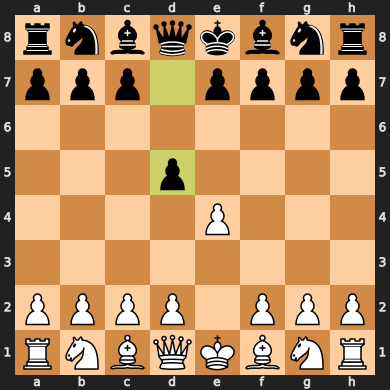

In [33]:
board

In [22]:
import chess

board = chess.Board()
move = board.push_san("e4")



uci_string = move.uci()

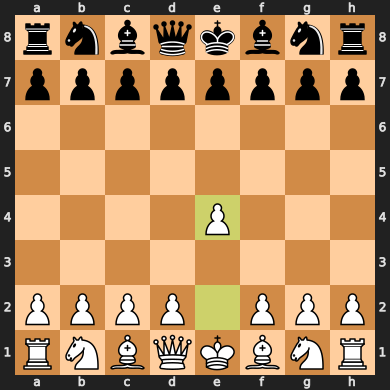

In [22]:
board

In [21]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


In [20]:
uci_string

'e2e4'

In [14]:
board = chess.Board()

In [15]:
board.push_san("e4")

Move.from_uci('e2e4')

In [16]:
str(Move.from_uci('e2e4'))

NameError: name 'Move' is not defined